In [66]:
## Install libraries
%pip install emoji
%pip install eli5
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
## Imports
import os
import pandas as pd
import numpy as np
#from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import re
import emoji
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import sklearn
import eli5
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from collections import Counter

In [31]:
## Pandas Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [65]:
## Connection to Google Drive
#drive.mount('/content/gdrive')

#path = '/content/gdrive/MyDrive/colab_notebooks/ML4NLP/Ex1'
#os.chdir(path)

In [33]:
## Helper Functions
def load_dataset(filename):
    df = pd.read_csv(filename, sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [34]:
## Load Data Sets
df_train_dev = load_dataset('https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv')
df_test = load_dataset('https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv')

training size:  (52675, 2)
test size:  (13279, 2)


en          35.1
ja          54.9
es          66.2
und         74.8
id          80.5
pt          86.0
ar          90.1
ru          92.0
fr          93.8
tr          95.1
th          95.9
ko          96.8
it          97.4
tl          98.1
nl          98.4
de          98.7
ms          99.0
pl          99.1
sv          99.2
el          99.3
he          99.3
zh-CN       99.4
sr          99.4
ca          99.5
fa          99.5
uk          99.5
vi          99.6
hi          99.6
hu          99.6
hi-Latn     99.6
fi          99.7
ur_LATN     99.7
ar_LATN     99.7
ro          99.7
no          99.8
su          99.8
zh-TW       99.8
jv          99.8
ta          99.8
sq          99.9
bn          99.9
ur          99.9
da          99.9
sw          99.9
hr          99.9
ne          99.9
bs          99.9
cs          99.9
gl         100.0
bg         100.0
et         100.0
km         100.0
hy         100.0
ht         100.0
sl         100.0
ps         100.0
az         100.0
xh         100.0
wo         100

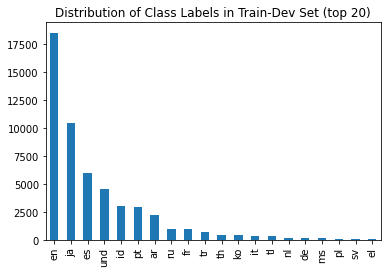

In [35]:
## Inspect the Data
print('training size: ', df_train_dev.shape)
print('test size: ', df_test.shape)

df_train_dev.label.value_counts()[0:20].plot(kind='bar', title='Distribution of Class Labels in Train-Dev Set (top 20)')
df_train_dev.label.value_counts(normalize=True).cumsum().round(3)*100

In [36]:
df_train_dev.label.describe()

count     52675
unique       69
top          en
freq      18508
Name: label, dtype: object

In [37]:
## Split the data into tweets and labels
X_train_dev = df_train_dev.tweet
y_train_dev = df_train_dev.label
X_test = df_test.tweet
y_test = df_test.label

In [38]:
## Split the train data into train and dev set according to 90/10 split
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.1, random_state=1)

In [39]:
## Define functions for preprocessing
def remove_url(text):
  re_url = re.compile('https?://\S+|www\.\S+')
  return re_url.sub('', text)

def remove_twitterUsername(text):
  re_user = re.compile(r'@([A-Za-z0-9_]+)')
  return re_user.sub('', text)

def convert_emojis(text):
  return emoji.demojize(text)

def pipelinize(function, active=True):
  def list_comprehend_a_function(list_or_series, active=True):
      if active:
          return [function(i) for i in list_or_series]
      else:
          return list_or_series
  return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})


def get_avg_word_length(text):
  if not text.split():
    return 0
  else:
    words = text.split()
    avg_word_length = sum(len(word) for word in words) / len(words)
    return avg_word_length

def get_tweet_length(text):
  return len(text)

def reshape_a_feature_column(series):
  return np.reshape(np.asarray(series), (len(series), 1))

def pipelinize_feature(function, active=True):
  def list_comprehend_a_function(list_or_series, active=True):
        if active:
            processed = [function(i) for i in list_or_series]
            processed = reshape_a_feature_column(processed)
            return processed
        else:
            return reshape_a_feature_column(np.zeros(len(list_or_series)))
  return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [40]:
## Create pipeline

# Define two extra linguistic features
linguistic_feature_1 = 'avg_word_length'
linguistic_feature_2 = 'tweet_length'

# Generate pipeline with LogisticRegression as classifier
pipeline = Pipeline([
    ('clean_URLs', pipelinize(remove_url)),
    ('clean_usernames', pipelinize(remove_twitterUsername)),
    ('clean_emojis', pipelinize(convert_emojis)),
    ('features', FeatureUnion([
        ('tf_idf_vectorizer', TfidfVectorizer()),
        (linguistic_feature_1 + '_scaled', Pipeline([
            (linguistic_feature_1, pipelinize_feature(get_avg_word_length, active=True)),
            ('scaler', StandardScaler())
            ])
        ),
        (linguistic_feature_2 + '_scaled', Pipeline([
            (linguistic_feature_2, pipelinize_feature(get_tweet_length, active=True)),
            ('scaler', StandardScaler())
            ])
        )
    ])),
    ('classifier', LogisticRegression())
  ])

In [41]:
## Define PredefinedSplit in order to use the 90/10 train and development (validation) split
## (k-fold CV does not work since this does not follow the 90/10 split as outlined in exercise statement)

train_size = len(y_train)
dev_size = len(y_dev)

X_train_dev = pd.concat([X_train, X_dev], ignore_index=True)
y_train_dev = pd.concat([y_train, y_dev], ignore_index=True)

# Set indices to be used for training (=first m elements of stacked train_dev array with m=len(y_train))
train_indices = np.full((train_size, ), -1, dtype=int)

# The indices which have zero or positive values, will be kept in dev
dev_indices = np.full((dev_size, ), 0, dtype=int)
fold = np.append(train_indices, dev_indices)

custom_split = PredefinedSplit(fold)

In [42]:
## GridSearch for optimal hyperparameter

# Define search space / hyperparameter grid
param_grid = {'classifier__penalty': ['l2', 'none'],
              'classifier__C': [0.1, 0.5, 1],
              'classifier__solver': ['newton-cg', 'lbfgs'],
              'classifier__max_iter': [2],
              'features__tf_idf_vectorizer__ngram_range': [(1, 1), (1, 2)],
              'features__tf_idf_vectorizer__max_features': [500, 1000]
              }

# Perform the GridSearch using the previously defined 90/10 train/development(validation) splits in the cross validation
grid_search = GridSearchCV(pipeline, param_grid, cv=custom_split, n_jobs=4, verbose=1, refit=True)

In [43]:
## Fitting (X_train_dev, y_train_dev will be split into train and dev(validation) set using the split defined above)
grid_search.fit(X_train_dev, y_train_dev)

Fitting 1 folds for each of 48 candidates, totalling 48 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('clean_URLs',
                                        FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fbe3a48b8c0>,
                                                            kw_args={'active': True})),
                                       ('clean_usernames',
                                        FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fbe3a48b3b0>,
                                                            kw_...
                                                                                        ('scaler',
                                                                                         StandardScaler())]))])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=4,
             param_grid={'classifier__C': [0.1, 0.5, 1],
   

In [44]:
print("Mean score (accuracy) on validation set: %0.3f" % grid_search.best_score_)
print("Best parameters set (measured by achieved score on development(validation) set):")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Mean score (accuracy) on validation set: 0.597
Best parameters set (measured by achieved score on development(validation) set):
	classifier__C: 0.1
	classifier__max_iter: 2
	classifier__penalty: 'none'
	classifier__solver: 'newton-cg'
	features__tf_idf_vectorizer__max_features: 1000
	features__tf_idf_vectorizer__ngram_range: (1, 1)


In [45]:
## Make predictions on unseen test set
y_pred = grid_search.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print("Mean score (accuracy) on unseen test set: %0.3f" % acc_test)

Mean score (accuracy) on unseen test set: 0.599


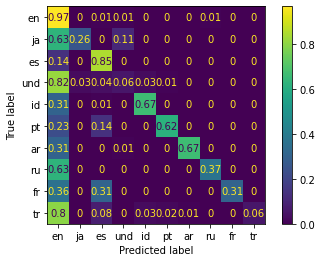

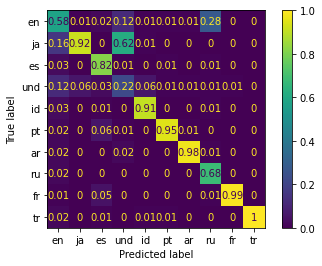

In [58]:
## Create confusion matrix

# Get 10 most common labels in test set for clearer visualizations of confusion matrix
c = Counter(y_test)
c_top10 = c.most_common(10)

labels_top10 = [i[0] for i in c_top10]

# Generate confusion matrix (normalized to True)
conf_mx = confusion_matrix(y_test, y_pred, normalize='true', labels=labels_top10).round(2)

disp = ConfusionMatrixDisplay(conf_mx, display_labels=labels_top10)
disp.plot()
plt.savefig('cm_lr_true.png')
plt.show()


# Generate confusion matrix (normalized to predictions)
conf_mx = confusion_matrix(y_test, y_pred, normalize='pred', labels=labels_top10).round(2)

disp = ConfusionMatrixDisplay(conf_mx, display_labels=labels_top10)
disp.plot()
plt.savefig('cm_lr_pred.png')
plt.show()

In [47]:
## Print the number of predictions for top 10 predicted classes
c = Counter(y_pred)
c_top10 = c.most_common(10)

print("Top 10 predicted classes: ")
print(c_top10)

Top 10 predicted classes: 
[('en', 8426), ('es', 1596), ('id', 652), ('th', 624), ('ja', 579), ('pt', 468), ('ar', 369), ('und', 347), ('ru', 134), ('fr', 74)]


In [64]:
## Create feature importance table

# Extract feature importance (=weights) from best classifier (i.e., best-performing according to Gridsearch)
best_estimator = grid_search.best_estimator_
classifier = best_estimator.named_steps['classifier']

# Extract feature names from the pipeline
feature_names_vectorizer = dict(best_estimator.named_steps['features'].transformer_list).get('tf_idf_vectorizer').get_feature_names_out()

# Account for extra linguistic features
feature_names_all = np.append(feature_names_vectorizer, [linguistic_feature_1, linguistic_feature_2])

# Display feature importance table
eli5.show_weights(classifier, feature_names=feature_names_all, top=10, targets=['en', 'es', 'ja'])